

# Gold Price Prediction

The goal of this case study is tu use classification based models to predict whether the current signal is **buy or sell** depending on the short term vs long term price.

## Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Libraries and Dataset](#1)
    * [2.1. Load Libraries](#1.1)    
    * [2.2. Load Dataset](#1.2)
* [3. Exploratory Data Analysis](#2)
    * [3.1 Descriptive Statistics](#2.1) 
* [4. Data Preparation](#3)
    * [4.1 Data Cleaning](#3.1)
    * [4.2. Preparing classification data](#3.2)
    * [4.3. Feature Engineering-Constructing Technical Indicators](#3.3)
    * [4.4.Data Visualisation](#3.4)
* [5.Evaluate Algorithms and Models](#4)        
    * [5.1. Train/Test Split](#4.1)
    * [5.2. Test Options and Evaluation Metrics](#4.2)
    * [5.3. Compare Models and Algorithms](#4.3) 
* [6. Model Tuning and Grid Search](#5)  
* [7. Finalize the Model](#6)  
    * [7.1. Results on test dataset](#6.1)
    * [7.1. Variable Intuition/Feature Selection](#6.2) 
* [8. Backtesting](#7)     


<a id='0'></a>
# 1. Problem Definition

The problem of predicting a buy or sell signal for a trading strategy is defined in the
classification framework, where the predicted variable has a value of 1 for buy and 0
for sell.

The buy or sell signal are decided on the basis on the comparison of short term vs. long
term price.


<a id='1'></a>
# 2. Getting Started- Loading the data and python packages

<a id='1.1'></a>
## 2.1. Loading the python packages

In [1]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from scikeras.wrappers import KerasClassifier


<a id='1.2'></a>
## 2.2. Loading the Data

In [2]:
import yfinance as yf


# === 1. Download gold futures data (GC=F) ===
dataset = yf.download('GC=F', start='1995-01-01')

# === 2. Reset index to convert Date to column ===
dataset.reset_index(inplace=True)

# === 3. Rename columns to match your original dataset format ===
dataset.rename(columns={
    'Date': 'Timestamp',
    'Adj Close': 'Close',  # If available; otherwise 'Close' remains
    'Volume': 'Volume_(Currency)'  # ✅ Rename only, no calculation
}, inplace=True)

# === 4. Compute Weighted Price (VWAP-style) ===
dataset['Weighted_Price'] = (dataset['High'] + dataset['Low'] + dataset['Close']) / 3

# === 5. Ensure Timestamp is datetime ===
dataset['Timestamp'] = pd.to_datetime(dataset['Timestamp'])

# === 6. Preview Final Dataset ===
print(dataset[['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume_(Currency)', 'Weighted_Price']].tail())

df = dataset

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Price   Timestamp         Open         High          Low        Close  \
Ticker                    GC=F         GC=F         GC=F         GC=F   
6161   2025-03-24  3024.300049  3024.300049  3006.000000  3013.100098   
6162   2025-03-25  3026.399902  3028.800049  3023.699951  3023.699951   
6163   2025-03-26  3033.199951  3033.199951  3019.500000  3020.899902   
6164   2025-03-27  3025.500000  3065.000000  3025.500000  3060.199951   
6165   2025-03-28  3099.300049  3124.399902  3096.300049  3112.399902   

Price  Volume_(Currency) Weighted_Price  
Ticker              GC=F                 
6161                 137    3014.466715  
6162                  74    3025.399984  
6163                  83    3024.533285  
6164                  83    3050.233317  
6165               57769    3111.033285  


<a id='2'></a>
# 3. Exploratory Data Analysis

<a id='2.1'></a>
## 3.1. Descriptive Statistics

In [3]:
# shape
dataset.shape

(6166, 7)

In [4]:
# peek at data
set_option('display.width', 100)
dataset.tail(5)

Price,Timestamp,Close,High,Low,Open,Volume_(Currency),Weighted_Price
Ticker,,GC=F,GC=F,GC=F,GC=F,GC=F,
6161,2025-03-24,3013.100098,3024.300049,3006.000000,3024.300049,137,3014.466715
6162,2025-03-25,3023.699951,3028.800049,3023.699951,3026.399902,74,3025.399984
6163,2025-03-26,3020.899902,3033.199951,3019.500000,3033.199951,83,3024.533285
6164,2025-03-27,3060.199951,3065.000000,3025.500000,3025.500000,83,3050.233317
6165,2025-03-28,3112.399902,3124.399902,3096.300049,3099.300049,57769,3111.033285


In [5]:
# describe data
set_option('display.precision', 3)
dataset.describe()

Price,Timestamp,Close,High,Low,Open,Volume_(Currency),Weighted_Price
Ticker,,GC=F,GC=F,GC=F,GC=F,GC=F,
count,6166,6166.000,6166.000,6166.000,6166.000,6166.000,6166.000
mean,2012-12-21 00:09:06.480700672,1177.601,1183.475,1171.520,1177.607,4284.313,1177.532
min,2000-08-30 00:00:00,255.100,256.100,255.000,255.000,0.000,255.733
25%,2006-11-06 06:00:00,634.925,637.750,633.350,635.250,21.000,635.200
50%,2012-12-20 12:00:00,1238.100,1243.500,1230.950,1237.450,108.000,1237.450
75%,2019-02-11 18:00:00,1637.475,1646.975,1626.575,1637.450,412.000,1637.917
max,2025-03-28 00:00:00,3112.400,3124.400,3096.300,3099.300,386334.000,3111.033
std,NaN,601.547,604.687,598.137,601.383,24262.450,601.433


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6166 entries, 0 to 6165
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   (Timestamp, )              6166 non-null   datetime64[ns]
 1   (Close, GC=F)              6166 non-null   float64       
 2   (High, GC=F)               6166 non-null   float64       
 3   (Low, GC=F)                6166 non-null   float64       
 4   (Open, GC=F)               6166 non-null   float64       
 5   (Volume_(Currency), GC=F)  6166 non-null   int64         
 6   (Weighted_Price, )         6166 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 337.3 KB


In [7]:
# Step 1: Flatten multi-index columns
df.columns = ['_'.join(filter(None, col)).strip() if isinstance(col, tuple) else col for col in df.columns]
# Step 2: Rename to your preferred format
df.rename(columns={
    'Close_GC=F': 'Close',
    'Open_GC=F': 'Open',
    'High_GC=F': 'High',
    'Low_GC=F': 'Low',
    'Volume_(Currency)_GC=F': 'Volume_(Currency)',
    'Timestamp': 'Timestamp',
    'Weighted_Price': 'Weighted_Price'
}, inplace=True)


In [8]:
print(df.dtypes)
print(df.tail())


Timestamp            datetime64[ns]
Close                       float64
High                        float64
Low                         float64
Open                        float64
Volume_(Currency)             int64
Weighted_Price              float64
dtype: object
      Timestamp   Close    High     Low    Open  Volume_(Currency)  Weighted_Price
6161 2025-03-24  3013.1  3024.3  3006.0  3024.3                137        3014.467
6162 2025-03-25  3023.7  3028.8  3023.7  3026.4                 74        3025.400
6163 2025-03-26  3020.9  3033.2  3019.5  3033.2                 83        3024.533
6164 2025-03-27  3060.2  3065.0  3025.5  3025.5                 83        3050.233
6165 2025-03-28  3112.4  3124.4  3096.3  3099.3              57769        3111.033


<Axes: title={'center': 'Gold Price (Close)'}, xlabel='Timestamp'>

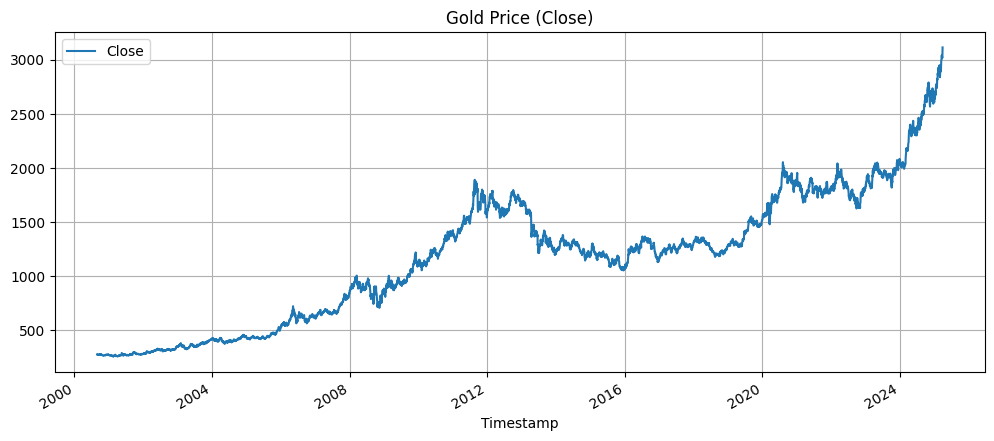

In [9]:
dataset.plot(x='Timestamp', y='Close', figsize=(12, 5), title='Gold Price (Close)', grid=True)


In [10]:
dataset['LogVolume'] = np.log1p(dataset['Volume_(Currency)'])


In [11]:
dataset.to_csv("clean_gold_data.csv", index=False)


<a id='3'></a>
# 4. Data Preparation

<a id='3.1'></a>
## 4.1. Data Cleaning

In [12]:
#Checking for any null values and removing the null values'''
print('Null Values =',dataset.isnull().values.any())

Null Values = False


Given that there are null values, we need to clean the data by filling the *NaNs* with the last available values. 

In [13]:
dataset[dataset.columns.values] = dataset[dataset.columns.values].ffill()

In [14]:
dataset=dataset.drop(columns=['Timestamp'])

<a id='3.2'></a>
## 4.2. Preparing the data for classification

We attach a label to each movement: 
* **1** if the signal is that short term price will go up as compared to the long term. 
* **0** if the signal is that short term price will go down as compared to the long term.

In [15]:
import numpy as np

# Create short and long simple moving averages
dataset['short_mavg'] = dataset['Close'].rolling(window=10, min_periods=1).mean()
dataset['long_mavg'] = dataset['Close'].rolling(window=60, min_periods=1).mean()

# Generate signal: 1 if short-term > long-term average, else 0
dataset['signal'] = np.where(dataset['short_mavg'] > dataset['long_mavg'], 1, 0)


In [16]:
dataset.tail()

,Close,High,Low,Open,Volume_(Currency),Weighted_Price,LogVolume,short_mavg,long_mavg,signal
6161,3013.1,3024.3,3006.0,3024.3,137,3014.467,4.927,2997.31,2835.315,1
6162,3023.7,3028.8,3023.7,3026.4,74,3025.400,4.317,3008.39,2841.730,1
6163,3020.9,3033.2,3019.5,3033.2,83,3024.533,4.431,3016.57,2848.458,1
6164,3060.2,3065.0,3025.5,3025.5,83,3050.233,4.431,3024.16,2856.027,1
6165,3112.4,3124.4,3096.3,3099.3,57769,3111.033,10.964,3035.95,2864.080,1


<a id='3.3'></a>
## 4.3. Feature Engineering

We begin by the constructing a dataset that contains the predictors which will be used to make the predictions, and the output variable.

The current Data of the gold consists of date, open, high, low, close and Volume. Using this data we calculate the following  technical indicators:
* **Moving Average** : A moving average provides an indication of the trend of the price movement by cut down the amount of "noise" on a price chart. 
* **Stochastic Oscillator %K and %D** : A stochastic oscillator is a momentum indicator comparing a particular closing price of a security to a range of its prices over a certain period of time. %K and %D are slow and fast indicators.
* **Relative Strength Index(RSI)** :It is a momentum indicator that measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of a stock or other asset. 
* **Rate Of Change(ROC)**: It is a momentum oscillator, which measures the percentage change between the current price and the n period past price. 
* **Momentum (MOM)** : It is the rate of acceleration of a security's price or volume – that is, the speed at which the price is changing.

In [17]:
#calculation of exponential moving average
def EMA(df, n):
    EMA = pd.Series(df['Close'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    return EMA
dataset['EMA10'] = EMA(dataset, 10)
dataset['EMA30'] = EMA(dataset, 30)
dataset['EMA200'] = EMA(dataset, 200)
dataset.head()

#calculation of rate of change
def ROC(df, n):  
    M = df.diff(n - 1)  
    N = df.shift(n - 1)  
    ROC = pd.Series(((M / N) * 100), name = 'ROC_' + str(n))   
    return ROC
dataset['ROC10'] = ROC(dataset['Close'], 10)
dataset['ROC30'] = ROC(dataset['Close'], 30)

#Calculation of price momentum
def MOM(df, n):   
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))   
    return MOM
dataset['MOM10'] = MOM(dataset['Close'], 10)
dataset['MOM30'] = MOM(dataset['Close'], 30)

#calculation of relative strength index
def RSI(series, period):
 delta = series.diff().dropna()
 u = delta * 0
 d = u.copy()
 u[delta > 0] = delta[delta > 0]
 d[delta < 0] = -delta[delta < 0]
 u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
 u = u.drop(u.index[:(period-1)])
 d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
 d = d.drop(d.index[:(period-1)])
 rs = u.ewm(com=period-1, adjust=False).mean() / \
 d.ewm(com=period-1, adjust=False).mean()
 return 100 - 100 / (1 + rs)
dataset['RSI10'] = RSI(dataset['Close'], 10)
dataset['RSI30'] = RSI(dataset['Close'], 30)
dataset['RSI200'] = RSI(dataset['Close'], 200)

#calculation of stochastic osillator.

def STOK(close, low, high, n): 
 STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 return STOK

def STOD(close, low, high, n):
 STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 STOD = STOK.rolling(3).mean()
 return STOD

dataset['%K10'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 10)
dataset['%D10'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 10)
dataset['%K30'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 30)
dataset['%D30'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 30)
dataset['%K200'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 200)
dataset['%D200'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 200)

In [18]:
#Calculation of moving average
def MA(df, n):
    MA = pd.Series(df['Close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    return MA
dataset['MA21'] = MA(dataset, 10)
dataset['MA63'] = MA(dataset, 30)
dataset['MA252'] = MA(dataset, 200)
dataset.tail()

,Close,High,Low,Open,Volume_(Currency),Weighted_Price,LogVolume,short_mavg,long_mavg,signal,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
6161,3013.1,3024.3,3006.0,3024.3,137,3014.467,4.927,2997.31,2835.315,1,...,58.160,77.830,84.096,82.565,87.485,95.062,96.455,2997.31,2938.787,2627.718
6162,3023.7,3028.8,3023.7,3026.4,74,3025.400,4.317,3008.39,2841.730,1,...,58.286,80.696,79.790,87.454,84.979,96.447,95.746,3008.39,2942.433,2630.984
6163,3020.9,3033.2,3019.5,3033.2,83,3024.533,4.431,3016.57,2848.458,1,...,58.239,74.071,77.532,86.162,85.394,96.055,95.855,3016.57,2946.047,2634.563
6164,3060.2,3065.0,3025.5,3025.5,83,3050.233,4.431,3024.16,2856.027,1,...,58.705,93.924,82.897,97.921,90.512,99.377,97.293,3024.16,2951.087,2638.325
6165,3112.4,3124.4,3096.3,3099.3,57769,3111.033,10.964,3035.95,2864.080,1,...,59.310,91.137,86.377,95.866,93.317,98.553,97.995,3035.95,2957.303,2642.350


In [19]:
dataset.tail()

,Close,High,Low,Open,Volume_(Currency),Weighted_Price,LogVolume,short_mavg,long_mavg,signal,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
6161,3013.1,3024.3,3006.0,3024.3,137,3014.467,4.927,2997.31,2835.315,1,...,58.160,77.830,84.096,82.565,87.485,95.062,96.455,2997.31,2938.787,2627.718
6162,3023.7,3028.8,3023.7,3026.4,74,3025.400,4.317,3008.39,2841.730,1,...,58.286,80.696,79.790,87.454,84.979,96.447,95.746,3008.39,2942.433,2630.984
6163,3020.9,3033.2,3019.5,3033.2,83,3024.533,4.431,3016.57,2848.458,1,...,58.239,74.071,77.532,86.162,85.394,96.055,95.855,3016.57,2946.047,2634.563
6164,3060.2,3065.0,3025.5,3025.5,83,3050.233,4.431,3024.16,2856.027,1,...,58.705,93.924,82.897,97.921,90.512,99.377,97.293,3024.16,2951.087,2638.325
6165,3112.4,3124.4,3096.3,3099.3,57769,3111.033,10.964,3035.95,2864.080,1,...,59.310,91.137,86.377,95.866,93.317,98.553,97.995,3035.95,2957.303,2642.350


In [20]:
#excluding columns that are not needed for our prediction.

dataset=dataset.drop(['High','Low','Open', 'Volume_(Currency)','short_mavg','long_mavg'], axis=1)

In [21]:
dataset = dataset.dropna(axis=0)

In [22]:
dataset.tail()

,Close,Weighted_Price,LogVolume,signal,EMA10,EMA30,EMA200,ROC10,ROC30,MOM10,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
6161,3013.1,3014.467,4.927,1,2997.306,2933.513,2645.103,3.440,3.390,122.1,...,58.160,77.830,84.096,82.565,87.485,95.062,96.455,2997.31,2938.787,2627.718
6162,3023.7,3025.400,4.317,1,3002.105,2939.332,2648.870,2.878,3.818,110.8,...,58.286,80.696,79.790,87.454,84.979,96.447,95.746,3008.39,2942.433,2630.984
6163,3020.9,3024.533,4.431,1,3005.522,2944.594,2652.572,1.226,3.847,81.8,...,58.239,74.071,77.532,86.162,85.394,96.055,95.855,3016.57,2946.047,2634.563
6164,3060.2,3050.233,4.431,1,3015.463,2952.053,2656.628,2.194,4.590,75.9,...,58.705,93.924,82.897,97.921,90.512,99.377,97.293,3024.16,2951.087,2638.325
6165,3112.4,3111.033,10.964,1,3033.088,2962.398,2661.163,3.747,7.935,117.9,...,59.310,91.137,86.377,95.866,93.317,98.553,97.995,3035.95,2957.303,2642.350


<a id='3.4'></a>
## 4.4. Data Visualization

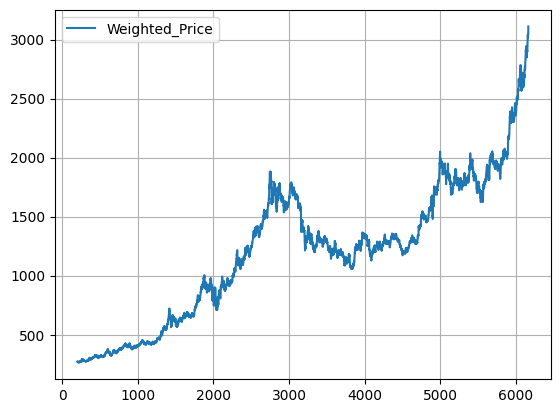

In [23]:
dataset[['Weighted_Price']].plot(grid=True)
plt.show()

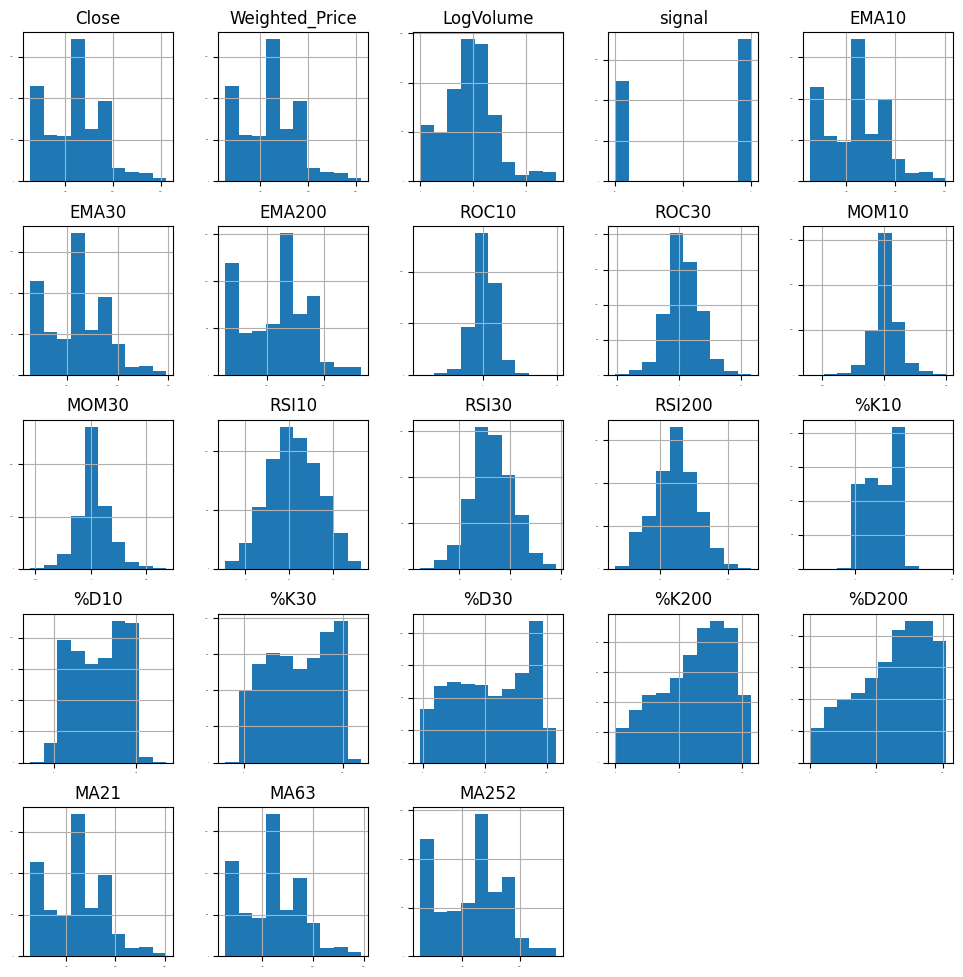

In [24]:
# histograms
dataset.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
plt.show()

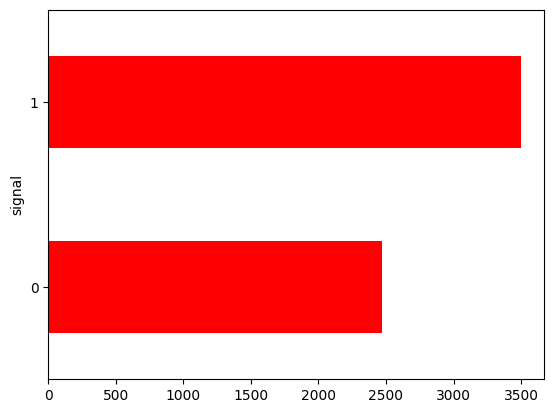

In [25]:
fig = plt.figure()
plot = dataset.groupby(['signal']).size().plot(kind='barh', color='red')
plt.show()

The predicted variable is upward 52.87% out of total data-size, meaning that number
of the buy signals were more than the number of sell signals. 

<Axes: title={'center': 'Correlation Matrix'}>

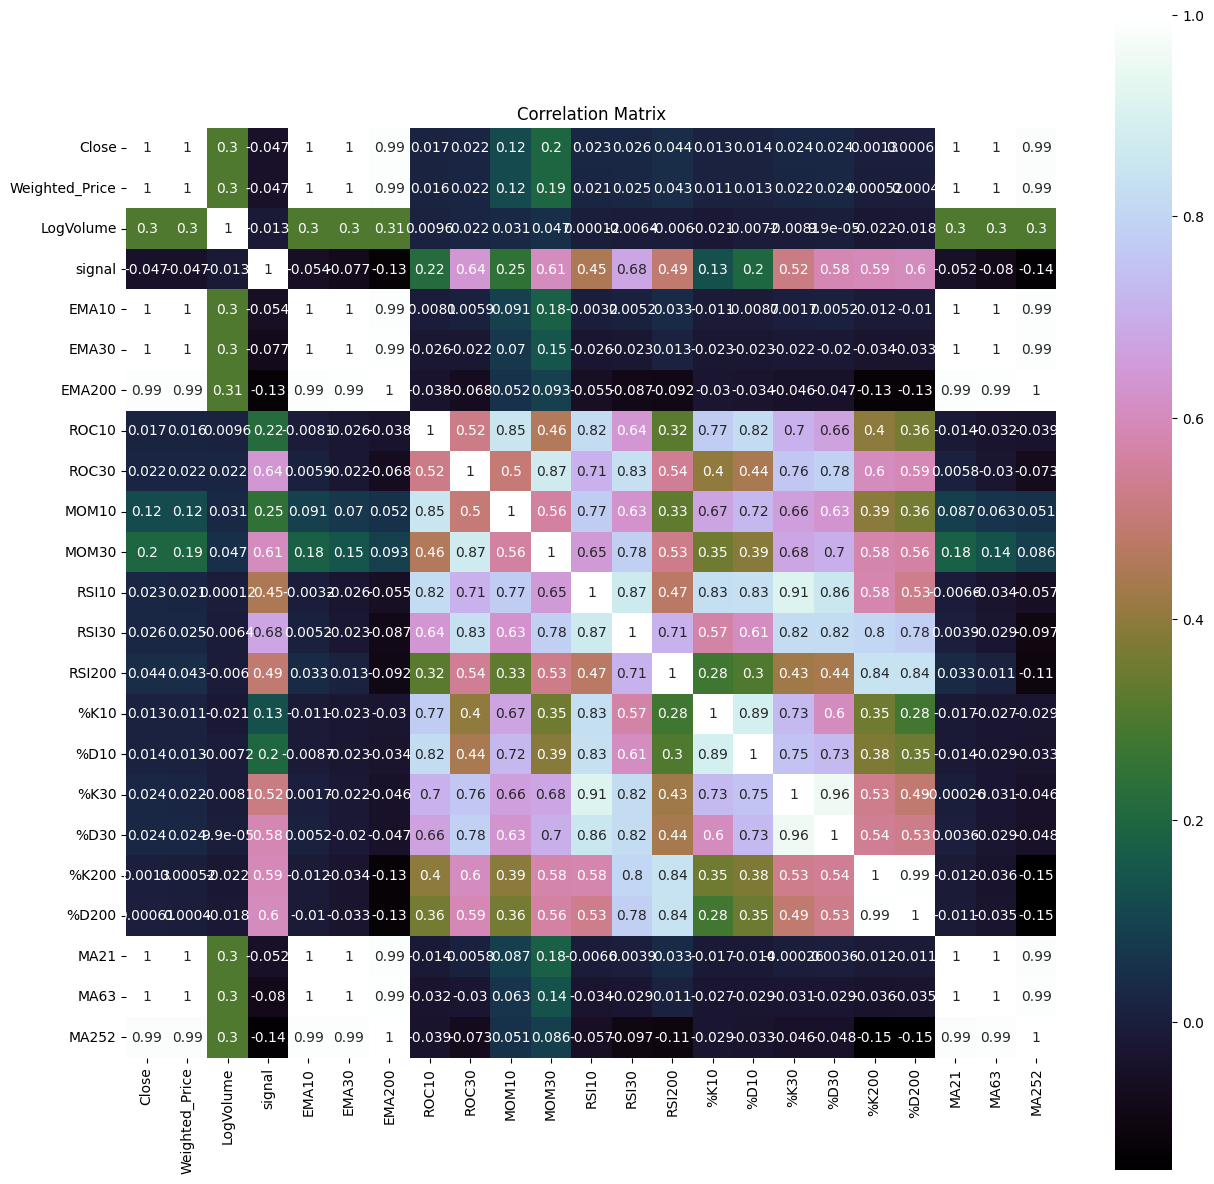

In [26]:
# correlation
correlation = dataset.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

<a id='4'></a>
# 5. Evaluate Algorithms and Models

<a id='4.1'></a>
## 5.1. Train Test Split

We split the dataset into 80% training set and 20% test set.

In [27]:
# split out validation dataset for the end
subset_dataset= dataset.iloc[-100000:]
Y= subset_dataset["signal"]
X = subset_dataset.loc[:, dataset.columns != 'signal']
validation_size = 0.2
seed = 1
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=1)

<a id='4.2'></a>
## 5.2. Test Options and Evaluation Metrics


In [28]:
# test options for classification
num_folds = 10
seed = 7
scoring = 'accuracy'
scoring = 'precision'
scoring = 'recall'
scoring ='neg_log_loss'
scoring = 'roc_auc'

<a id='4.3'></a>
## 5.3. Compare Models and Algorithms

In order to know which algorithm technic is the best for our strategy, we evaluate following non linear different methods:

<a id='4.3.1'></a>
### 5.3.1. Models

In [29]:
# spot check the algorithms
models = []
models.append(('LR', LogisticRegression(n_jobs=-1)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
#Neural Network
models.append(('NN', MLPClassifier()))
#Ensable Models 
# Boosting methods
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
# Bagging methods
models.append(('RF', RandomForestClassifier(n_jobs=-1)))

### K-folds cross validation

In [30]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.978372 (0.007840)
LDA: 0.981642 (0.003875)
KNN: 0.979904 (0.004491)
CART: 0.895870 (0.012879)
NB: 0.892820 (0.011098)
NN: 0.935375 (0.020081)
AB: 0.977178 (0.004867)
GBM: 0.984258 (0.004313)
RF: 0.985848 (0.004107)


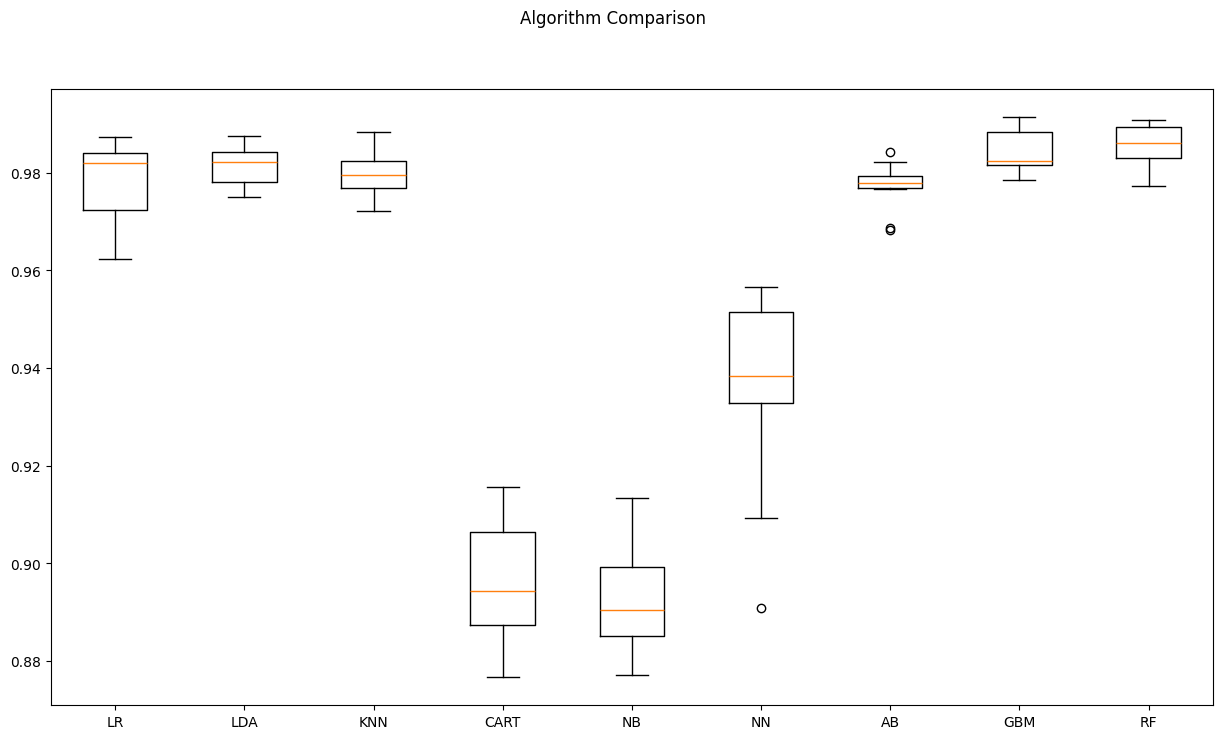

In [31]:
# compare algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

<a id='5'></a>
# 6. Model Tuning and Grid Search

Random forest is selected for the grid search as it is one of the best models out of all.

In [32]:
# Grid Search: Random Forest Classifier
'''
n_estimators : int (default=100)
    The number of boosting stages to perform. 
    Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.
max_depth : integer, optional (default=3)
    maximum depth of the individual regression estimators. 
    The maximum depth limits the number of nodes in the tree. 
    Tune this parameter for best performance; the best value depends on the interaction of the input variables    
criterion : string, optional (default=”gini”)
    The function to measure the quality of a split. 
    Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. 
    
'''   
# === Step 2: Standardize the training features ===
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)

# === Step 3: Define parameter grid ===
param_grid = {
    'n_estimators': [20, 80],
    'max_depth': [5, 10],
    'criterion': ['gini', 'entropy']
}

# === Step 4: Set up model and CV ===
model = RandomForestClassifier(n_jobs=-1)
num_folds = 10
seed = 7
scoring = 'accuracy'

kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)  # ✅ shuffle enabled

# === Step 5: Run Grid Search ===
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

# === Step 6: Display Best Results ===
print(f"Best Score: {grid_result.best_score_:.4f}")
print(f"Best Params: {grid_result.best_params_}")

# Detailed results
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']

print("\nGrid Search Results (sorted):")
sorted_results = sorted(zip(ranks, means, stds, params))
for rank, mean, std, param in sorted_results:
    print(f"#{rank}: {mean:.4f} ({std:.4f}) with {param}")


Best Score: 0.9311
Best Params: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 80}

Grid Search Results (sorted):
#1: 0.9311 (0.0149) with {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 80}
#2: 0.9311 (0.0144) with {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 80}
#3: 0.9288 (0.0125) with {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 20}
#4: 0.9258 (0.0152) with {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 20}
#5: 0.8973 (0.0093) with {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 20}
#6: 0.8948 (0.0143) with {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 80}
#7: 0.8944 (0.0113) with {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 80}
#8: 0.8925 (0.0109) with {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 20}


<a id='6'></a>
# 7. Finalise the Model

Finalizing the model with best parameters found during tuning step.

<a id='6.1'></a>
## 7.1. Results on the Test Dataset

In [33]:
# prepare model
model = RandomForestClassifier(criterion='gini', n_estimators=80,max_depth=10,n_jobs=-1) # rbf is default kernel
#model = LogisticRegression() 
model.fit(X_train, Y_train)

RandomForestClassifier(max_depth=10, n_estimators=80, n_jobs=-1)

In [34]:
# estimate accuracy on validation set
predictions = model.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.9354568315171836
[[452  21]
 [ 56 664]]
              precision    recall  f1-score   support

           0       0.89      0.96      0.92       473
           1       0.97      0.92      0.95       720

    accuracy                           0.94      1193
   macro avg       0.93      0.94      0.93      1193
weighted avg       0.94      0.94      0.94      1193



<Axes: xlabel='Predicted', ylabel='Actual'>

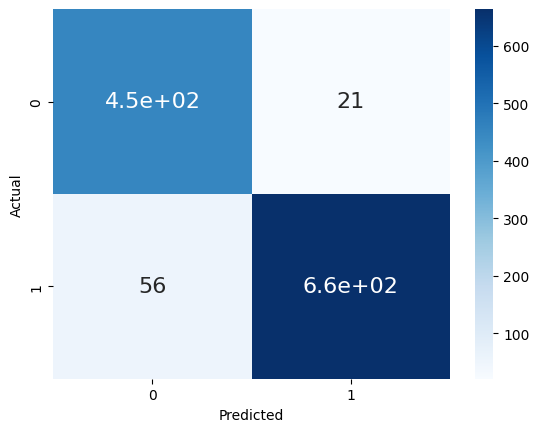

In [35]:
df_cm = pd.DataFrame(confusion_matrix(Y_validation, predictions), columns=np.unique(Y_validation), index = np.unique(Y_validation))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font sizes

<a id='6.2'></a>
## 7.2. Variable Intuition/Feature Importance
Let us look into the Feature Importance of the model

Text(0.5, 0, 'Variable Importance')

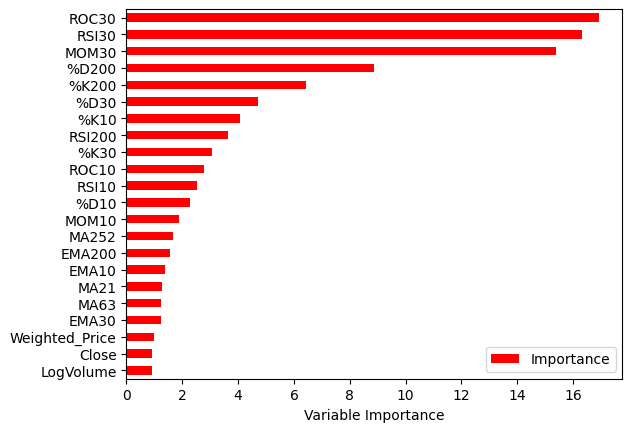

In [36]:
Importance = pd.DataFrame({'Importance':model.feature_importances_*100}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r' )
plt.xlabel('Variable Importance')

<a id='7'></a>
## 8. Backtesting Results

<Axes: >

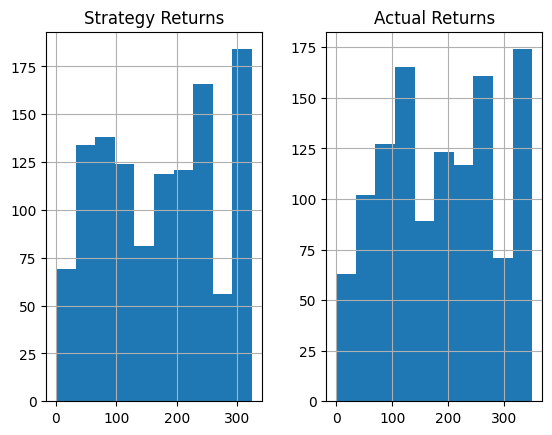

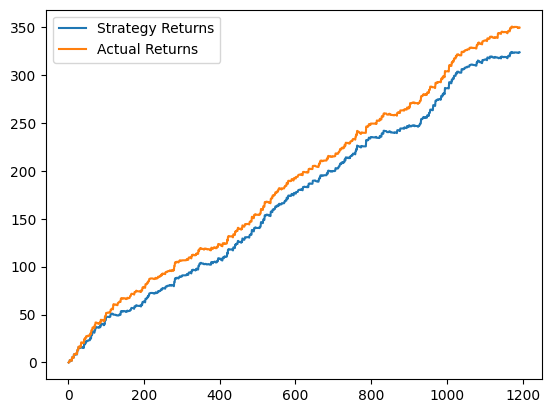

In [37]:
#Create column for Strategy Returns by multiplying the daily returns by the position that was held at close
#of business the previous day
backtestdata = pd.DataFrame(index=X_validation.index)
#backtestdata = pd.DataFrame()
backtestdata['signal_pred'] = predictions
backtestdata['signal_actual'] = Y_validation
backtestdata['Market Returns'] = X_validation['Close'].pct_change()
backtestdata['Actual Returns'] = backtestdata['Market Returns'] * backtestdata['signal_actual'].shift(1)
backtestdata['Strategy Returns'] = backtestdata['Market Returns'] * backtestdata['signal_pred'].shift(1)
backtestdata=backtestdata.reset_index()
backtestdata.head()
backtestdata[['Strategy Returns','Actual Returns']].cumsum().hist()
backtestdata[['Strategy Returns','Actual Returns']].cumsum().plot()

In [38]:
def max_drawdown(series):
    cumulative = series.cumsum()
    running_max = cumulative.cummax()
    drawdown = (cumulative - running_max)
    return drawdown.min()

print("Max Drawdown (Strategy):", max_drawdown(backtestdata['Strategy Returns']))
print("Max Drawdown (Actual):", max_drawdown(backtestdata['Actual Returns']))


Max Drawdown (Strategy): -2.773216318642028
Max Drawdown (Actual): -3.2271489890480325


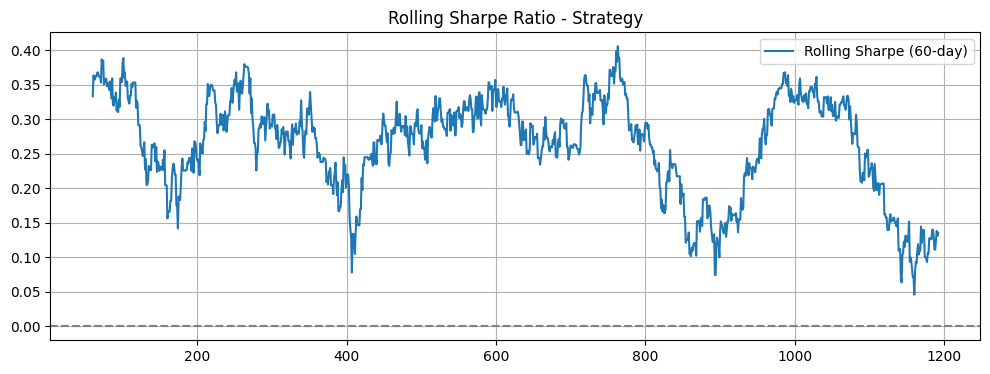

In [39]:
window = 60
rolling_sharpe = backtestdata['Strategy Returns'].rolling(window).mean() / backtestdata['Strategy Returns'].rolling(window).std()

plt.figure(figsize=(12, 4))
plt.plot(rolling_sharpe, label='Rolling Sharpe (60-day)')
plt.axhline(0, color='gray', linestyle='--')
plt.title("Rolling Sharpe Ratio - Strategy")
plt.legend()
plt.grid(True)
plt.show()


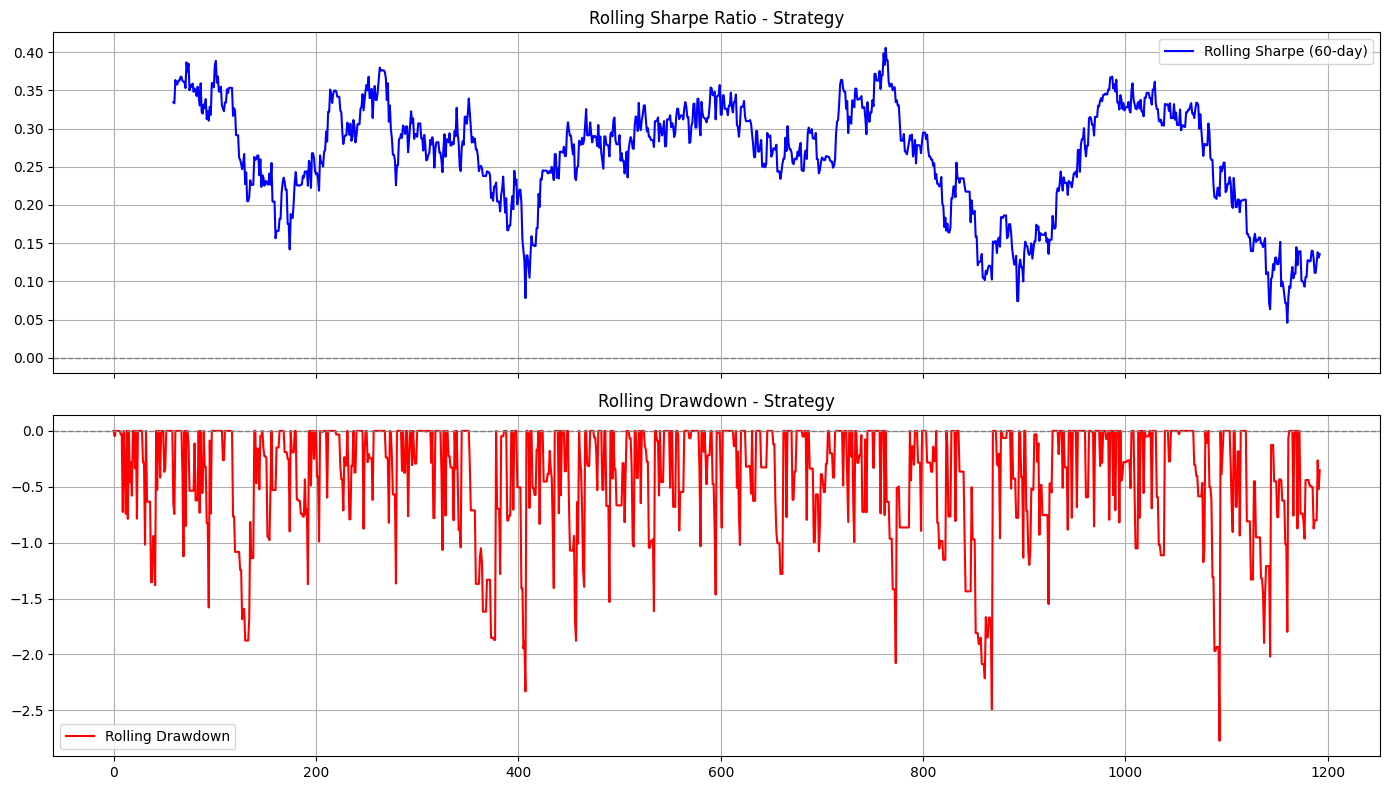

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure Strategy Returns column has no NaNs
strategy_returns = backtestdata['Strategy Returns'].fillna(0)

# Calculate Rolling Sharpe (60-day window)
rolling_window = 60
rolling_sharpe = strategy_returns.rolling(window=rolling_window).mean() / strategy_returns.rolling(window=rolling_window).std()

# Calculate Cumulative Returns
cumulative_returns = strategy_returns.cumsum()

# Calculate Rolling Max and Drawdown
rolling_max = cumulative_returns.cummax()
drawdown = cumulative_returns - rolling_max

# === Plotting ===
fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Rolling Sharpe Plot
axs[0].plot(rolling_sharpe, label='Rolling Sharpe (60-day)', color='blue')
axs[0].axhline(0, color='gray', linestyle='--', linewidth=1)
axs[0].set_title("Rolling Sharpe Ratio - Strategy")
axs[0].legend()
axs[0].grid(True)

# Rolling Drawdown Plot
axs[1].plot(drawdown, label='Rolling Drawdown', color='red')
axs[1].axhline(0, color='gray', linestyle='--', linewidth=1)
axs[1].set_title("Rolling Drawdown - Strategy")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


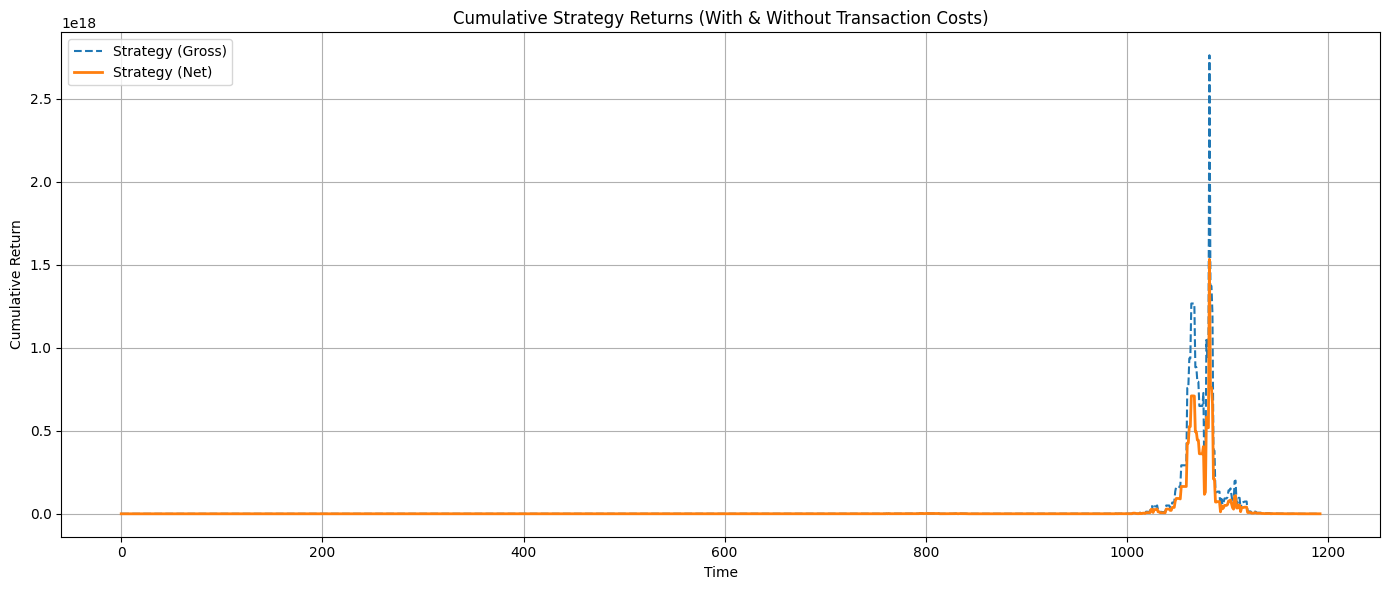

In [41]:
# Reuse backtestdata and simulate transaction costs

# Define transaction cost rate (e.g., 0.1% per trade)
transaction_cost = 0.001  # 0.1%

# Calculate position changes (entry/exit)
backtestdata['Position Change'] = backtestdata['signal_pred'].fillna(0).diff().abs()

# Apply transaction cost when position changes
backtestdata['Transaction Cost'] = backtestdata['Position Change'] * transaction_cost

# Subtract cost from strategy returns
backtestdata['Net Strategy Returns'] = backtestdata['Strategy Returns'] - backtestdata['Transaction Cost']

# Cumulative returns
backtestdata['Cumulative Net Strategy'] = (1 + backtestdata['Net Strategy Returns'].fillna(0)).cumprod()
backtestdata['Cumulative Gross Strategy'] = (1 + backtestdata['Strategy Returns'].fillna(0)).cumprod()

# Plot comparison
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(backtestdata['Cumulative Gross Strategy'], label='Strategy (Gross)', linestyle='--')
plt.plot(backtestdata['Cumulative Net Strategy'], label='Strategy (Net)', linewidth=2)
plt.title("Cumulative Strategy Returns (With & Without Transaction Costs)")
plt.xlabel("Time")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [42]:
backtestdata.to_csv("gold_model_backtest_results.csv", index=False)


__Conclusion__:

We showed that framing the problem is the first priority and we address it by engi‐
neering the features and transforming the labels according to the investment objective.

We demonstrated the efficiency of using feature engineering that leads to creation of
intuitive features related to the trend and momentum of the price movement and
increases the predictive power of the model.

In terms of the evaluation metrics for a classification-based trading strategy, accuracy
or auc are appropriate, but in case the strategy is focusing to be more accurate while
going long, the metric recall which focuses on less false positive can be preferred as
compared to accuracy.

Finally, we demonstrated the backtesting framework which allows us to simulate a
trading strategy using historical data to generate results and analyze risk and profita‐
bility before risking any actual capital.


# 📈 Gold Price Forecasting Module (ARIMA-based)

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from datetime import timedelta
from pmdarima import auto_arima

import itertools
import statsmodels.api as sm


Best ARIMA order: (2, 1, 1)


d:\Microsoft VS Code\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Microsoft VS Code\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Microsoft VS Code\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


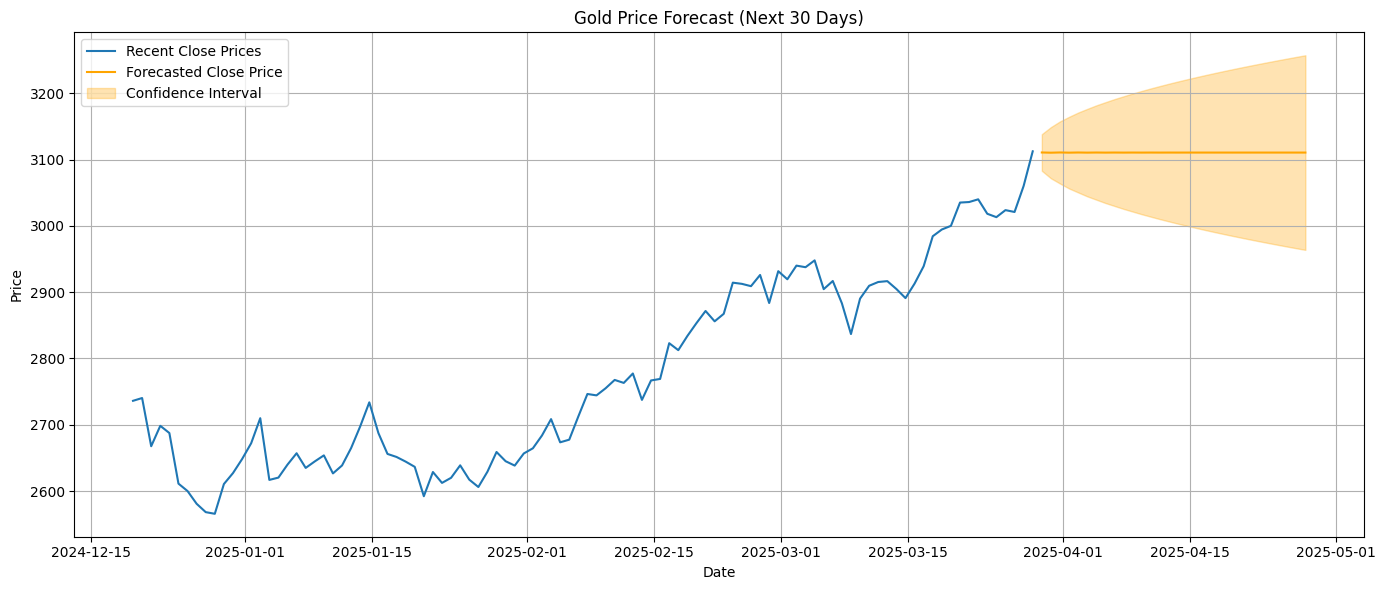

In [44]:
# === Auto-ARIMA Forecast the next N days of Close price ===
def forecast_gold_price(dataset, steps=30, plot=True):
    """
    Forecast gold prices using auto-ARIMA for optimal parameter selection.
    
    Parameters:
    - dataset: DataFrame containing 'Close' price
    - steps: Number of days to forecast
    - plot: If True, show forecast plot
    
    Returns:
    - forecast_df: DataFrame with forecasted prices and confidence intervals
    """
    # Step 1: Prepare Close series
    df = dataset.copy()
    df['Date'] = pd.date_range(end=pd.Timestamp.today(), periods=len(df))
    df.set_index('Date', inplace=True)
    df = df.sort_index()
    close_series = df['Close'].dropna()

    # Step 2: Auto ARIMA to find optimal (p,d,q)
    auto_model = auto_arima(close_series, start_p=0, start_q=0,
                            max_p=5, max_q=5, seasonal=False, d=None,
                            trace=False, error_action='ignore', suppress_warnings=True)
    print(f"Best ARIMA order: {auto_model.order}")

    # Step 3: Fit statsmodels ARIMA model with best params
    best_order = auto_model.order
    model = ARIMA(close_series, order=best_order)
    model_fit = model.fit()

    # Step 4: Forecast
    forecast_result = model_fit.get_forecast(steps=steps)
    forecast = forecast_result.predicted_mean
    conf_int = forecast_result.conf_int()

    # Step 5: Forecast index (future dates)
    last_date = close_series.index[-1]
    forecast_index = [last_date + timedelta(days=i) for i in range(1, steps + 1)]

    # Step 6: Plotting
    if plot:
        plt.figure(figsize=(14, 6))
        plt.plot(close_series[-100:], label='Recent Close Prices')
        plt.plot(forecast_index, forecast, label='Forecasted Close Price', color='orange')
        plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], 
                         color='orange', alpha=0.3, label='Confidence Interval')
        plt.title("Gold Price Forecast (Next {} Days)".format(steps))
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # Step 7: Return forecast DataFrame
    return pd.DataFrame({
        'Date': forecast_index,
        'Forecast': forecast.values,
        'Lower Bound': conf_int.iloc[:, 0].values,
        'Upper Bound': conf_int.iloc[:, 1].values
    })

# === Example usage ===
forecast_df = forecast_gold_price(dataset, steps=30)
forecast_df.to_csv("gold_price_forecast.csv", index=False)


Best SARIMA order: (2, 1, 1) x (0, 0, 0, 12)


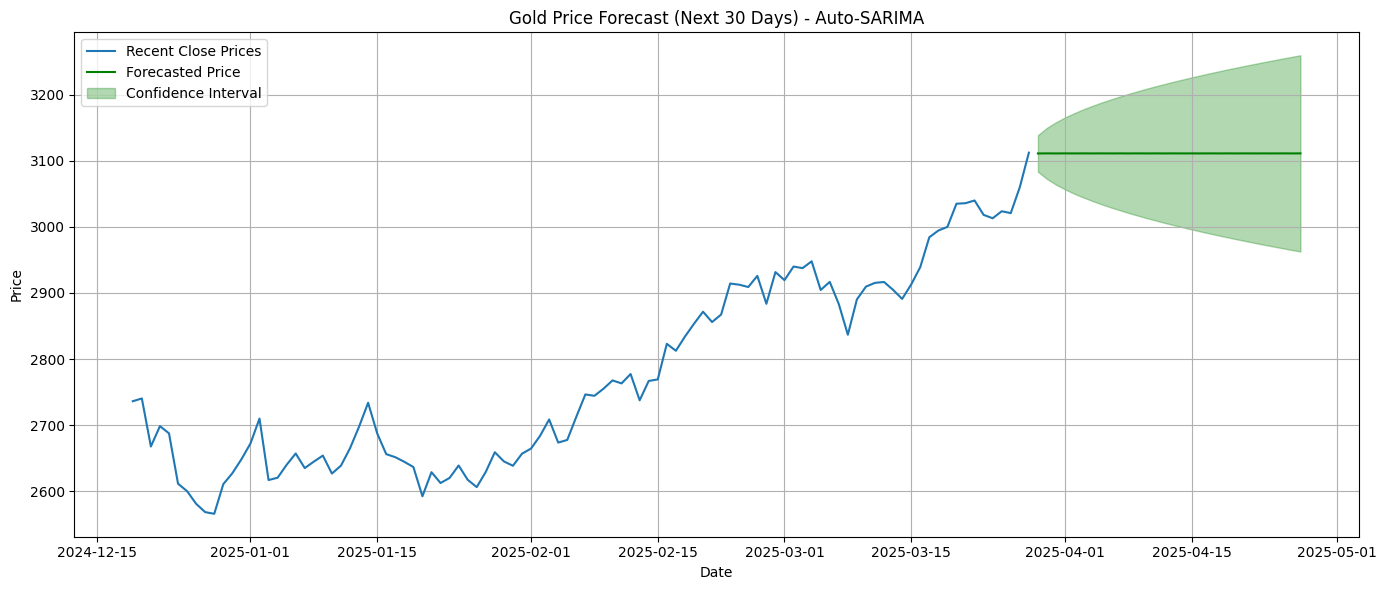

In [45]:
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

# === Auto-SARIMA Forecast the next N days of Close price ===
def forecast_gold_price_sarima(dataset, steps=30, plot=True):
    """
    Forecast gold prices using auto-SARIMA for optimal (p,d,q)(P,D,Q,m).
    
    Parameters:
    - dataset: DataFrame with 'Close' column
    - steps: Number of forecast steps
    - plot: Show forecast chart if True

    Returns:
    - forecast_df: DataFrame with forecast + confidence intervals
    """
    # Step 1: Prepare Close time series
    df = dataset.copy()
    df['Date'] = pd.date_range(end=pd.Timestamp.today(), periods=len(df))
    df.set_index('Date', inplace=True)
    df = df.sort_index()
    close_series = df['Close'].dropna()
    close_series.index = pd.DatetimeIndex(close_series.index).to_period("D")  # Ensure valid frequency
        # === Step 1: Prepare series ===

    # Step 2: Auto-SARIMA model selection
    auto_model = auto_arima(
        close_series, 
        start_p=0, start_q=0, 
        max_p=3, max_q=3, 
        seasonal=True, 
        m=12,  # Monthly seasonality
        D=None, 
        trace=False, 
        error_action='ignore', 
        suppress_warnings=True
    )
    
    print(f"Best SARIMA order: {auto_model.order} x {auto_model.seasonal_order}")

    # Step 3: Fit SARIMAX model using statsmodels
    model = SARIMAX(
        close_series, 
        order=auto_model.order, 
        seasonal_order=auto_model.seasonal_order,
        enforce_stationarity=False, 
        enforce_invertibility=False
    )
    model_fit = model.fit(disp=False)

    # Step 4: Forecasting
    forecast_result = model_fit.get_forecast(steps=steps)
    forecast = forecast_result.predicted_mean
    conf_int = forecast_result.conf_int()

    # Step 5: Forecast index
    last_date = close_series.index[-1].to_timestamp()
    forecast_index = [last_date + timedelta(days=i) for i in range(1, steps + 1)]

    # Step 6: Plot
    if plot:
        plt.figure(figsize=(14, 6))
        plt.plot(close_series[-100:].to_timestamp(), label='Recent Close Prices')
        plt.plot(forecast_index, forecast, label='Forecasted Price', color='green')
        plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1],
                         color='green', alpha=0.3, label='Confidence Interval')
        plt.title(f"Gold Price Forecast (Next {steps} Days) - Auto-SARIMA")
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # Step 7: Return results
    return pd.DataFrame({
        'Date': forecast_index,
        'Forecast': forecast.values,
        'Lower Bound': conf_int.iloc[:, 0].values,
        'Upper Bound': conf_int.iloc[:, 1].values
    })
# Usage 
forecast_sarima_df = forecast_gold_price_sarima(dataset, steps=30)
forecast_sarima_df.to_csv("gold_price_forecast_sarima.csv", index=False)


In [59]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import timedelta
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def forecast_multiple_horizons(dataset, order=(2,1,1), seasonal_order=(0,0,0,12)):
    """
    Forecast gold price for daily, weekly, monthly, and yearly horizons using SARIMA.
    """

    # === Step 1: Prepare series ===
    df = dataset.copy()
    df['Date'] = pd.date_range(end=pd.Timestamp.today(), periods=len(df))
    df.set_index('Date', inplace=True)
    df = df.sort_index()
    close_series = df['Close'].dropna()
    close_series.index = pd.DatetimeIndex(close_series.index).to_period("D")  # Ensure valid frequency


    # === Step 2: Fit SARIMA ===
    model = SARIMAX(close_series, order=order, seasonal_order=seasonal_order,
                    enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit(disp=False)

    # === Helper to forecast & plot ===
    def forecast_plot(title, steps, freq_label):
        forecast_result = model_fit.get_forecast(steps=steps)
        forecast = forecast_result.predicted_mean
        conf_int = forecast_result.conf_int()

        last_date = close_series.index[-1].to_timestamp()
        forecast_index = [last_date + timedelta(days=i) for i in range(1, steps + 1)]

        plt.figure(figsize=(16, 6))  # Wider figure for date scale
        historical = close_series.to_timestamp()
        historical = historical[historical.index >= pd.Timestamp("2025-01-01")]
        plt.plot(historical, label='Recent Close Prices', color='steelblue')

        # Forecast line
        plt.plot(forecast_index, forecast, label='Forecasted Price', color='darkgreen')

        # Confidence interval shading
        plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1],
                        color='green', alpha=0.3, label='Confidence Interval')

        # Title and axis labels
        plt.title(f"Gold Price Forecast ({title}) - SARIMA", fontsize=14)
        plt.xlabel("Date")
        plt.ylabel("Price")

        # Legend and grid
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()



        df = pd.DataFrame({
            'Date': forecast_index,
            f'{freq_label}_Forecast': forecast.values,
            'Lower Bound': conf_int.iloc[:, 0].values,
            'Upper Bound': conf_int.iloc[:, 1].values
        })
        return df

    # === Forecasts ===
    daily_df   = forecast_plot("Daily",   steps=7,     freq_label="Daily")
    weekly_df  = forecast_plot("Weekly",  steps=28,    freq_label="Weekly")   # 4 weeks
    monthly_df = forecast_plot("Monthly", steps=180,   freq_label="Monthly")  # 6 months
    yearly_df  = forecast_plot("Yearly",  steps=730,   freq_label="Yearly")   # 2 years

    return {
        'daily': daily_df,
        'weekly': weekly_df,
        'monthly': monthly_df,
        'yearly': yearly_df
    }


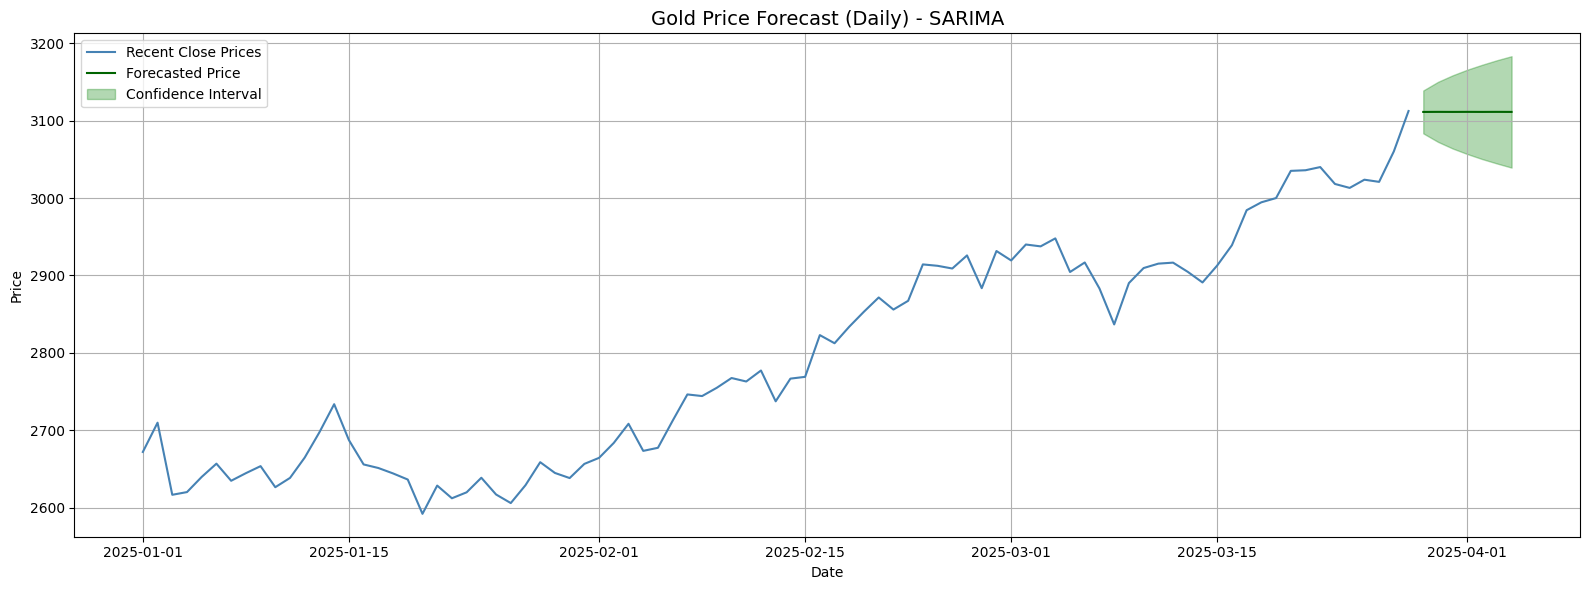

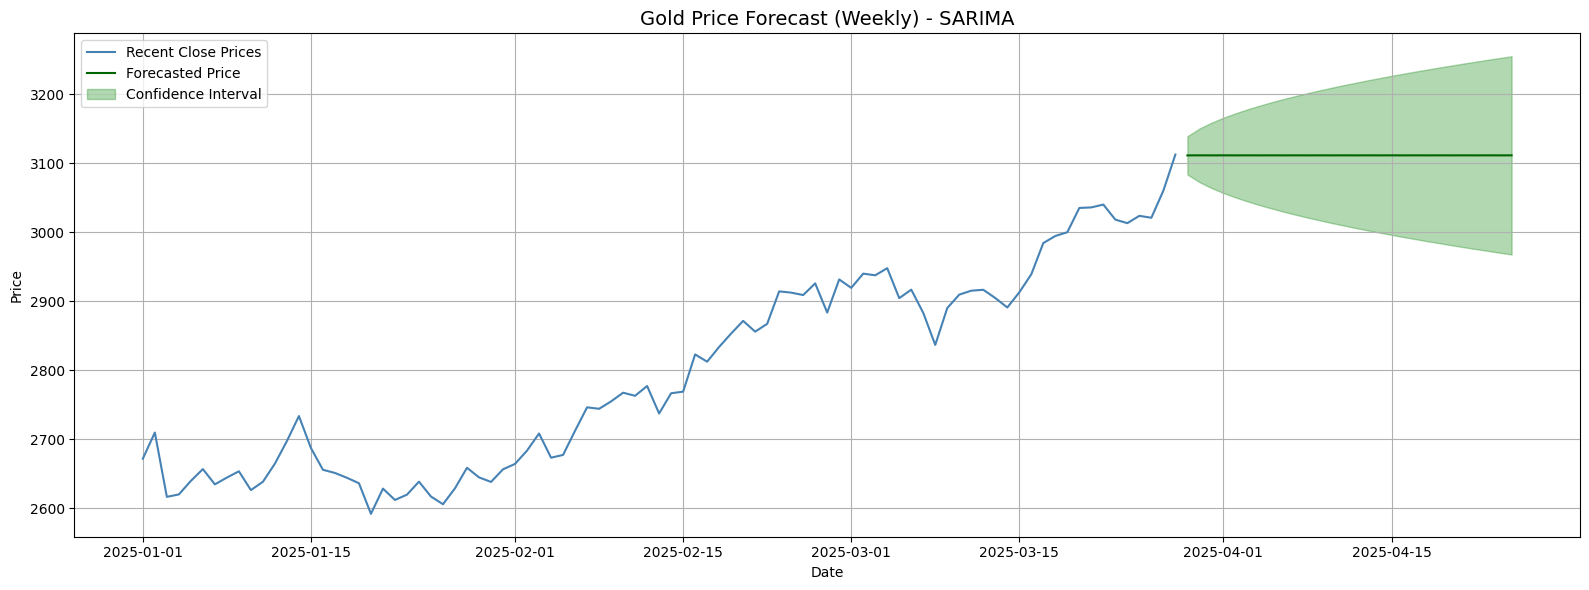

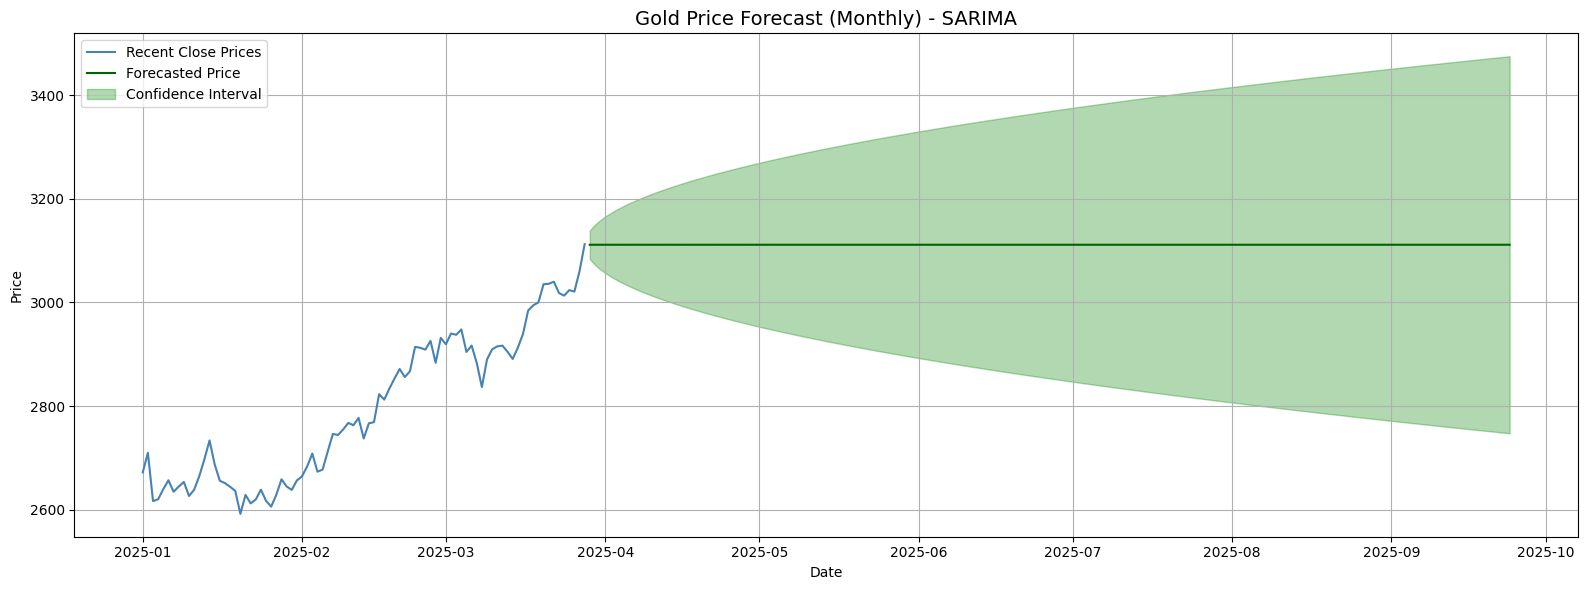

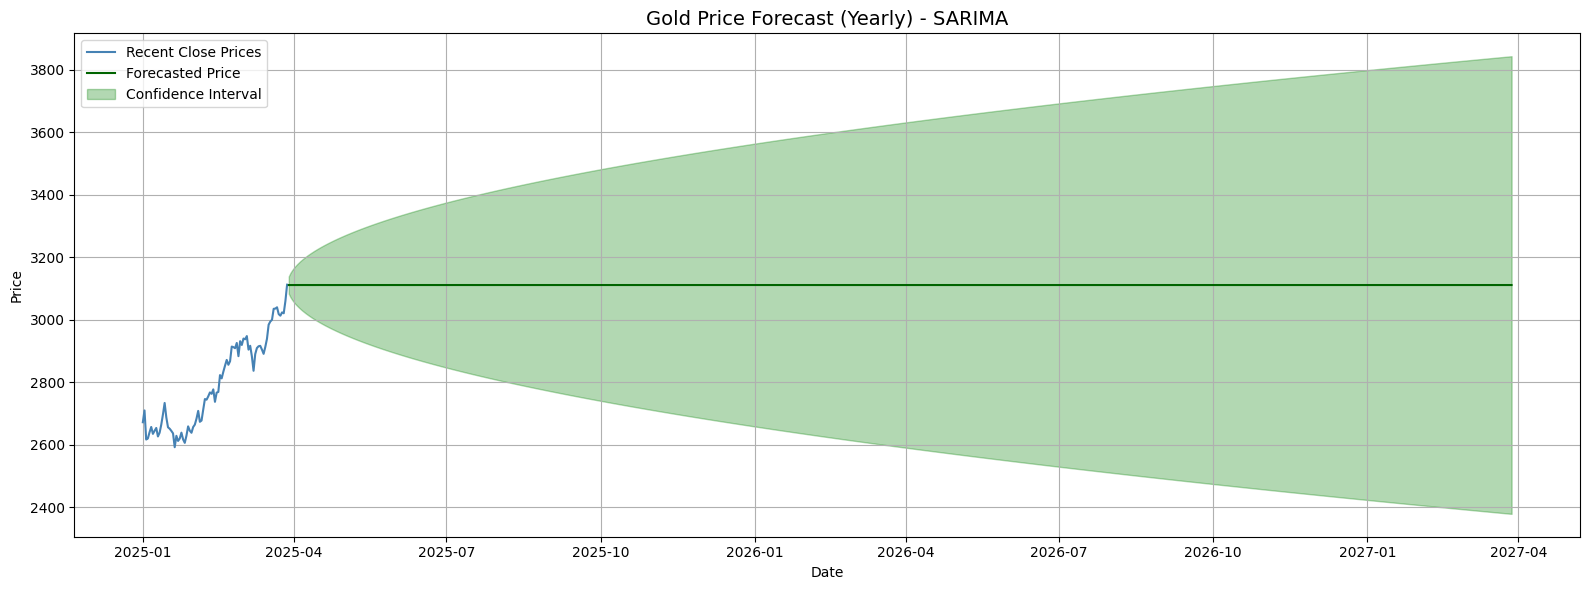

In [60]:
forecast_horizons = forecast_multiple_horizons(dataset)

# Export if needed:
forecast_horizons['daily'].to_csv("forecast_daily.csv", index=False)


In [48]:
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

# === Auto-SARIMA Forecast the next N days of Close price ===
def forecast_gold_price_sarima(dataset, steps=30, plot=True):
    """
    Forecast gold prices using auto-SARIMA for optimal (p,d,q)(P,D,Q,m).
    
    Parameters:
    - dataset: DataFrame with 'Close' column
    - steps: Number of forecast steps
    - plot: Show forecast chart if True

    Returns:
    - forecast_df: DataFrame with forecast + confidence intervals
    """
    # Step 1: Prepare Close time series
    df = dataset.copy()
    df['Date'] = pd.date_range(end=pd.Timestamp.today(), periods=len(df))
    df.set_index('Date', inplace=True)
    df = df.sort_index()
    close_series = df['Close'].dropna()
    close_series.index = pd.DatetimeIndex(close_series.index).to_period("D")  # Ensure valid frequency

    # Step 2: Auto-SARIMA model selection
    auto_model = auto_arima(
        close_series, 
        start_p=0, start_q=0, 
        max_p=3, max_q=3, 
        seasonal=True, 
        m=12,  # Monthly seasonality
        D=None, 
        trace=False, 
        error_action='ignore', 
        suppress_warnings=True
    )
    
    print(f"Best SARIMA order: {auto_model.order} x {auto_model.seasonal_order}")

    # Step 3: Fit SARIMAX model using statsmodels
    model = SARIMAX(
        close_series, 
        order=auto_model.order, 
        seasonal_order=auto_model.seasonal_order,
        enforce_stationarity=False, 
        enforce_invertibility=False
    )
    model_fit = model.fit(disp=False)

    # Step 4: Forecasting
    forecast_result = model_fit.get_forecast(steps=steps)
    forecast = forecast_result.predicted_mean
    conf_int = forecast_result.conf_int()

    # Step 5: Forecast index
    last_date = close_series.index[-1].to_timestamp()
    forecast_index = [last_date + timedelta(days=i) for i in range(1, steps + 1)]

    # Step 6: Plot
    if plot:
        plt.figure(figsize=(14, 6))
        plt.plot(close_series[-100:].to_timestamp(), label='Recent Close Prices')
        plt.plot(forecast_index, forecast, label='Forecasted Price', color='green')
        plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1],
                         color='green', alpha=0.3, label='Confidence Interval')
        plt.title(f"Gold Price Forecast (Next {steps} Days) - Auto-SARIMA")
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # Step 7: Return results
    return pd.DataFrame({
        'Date': forecast_index,
        'Forecast': forecast.values,
        'Lower Bound': conf_int.iloc[:, 0].values,
        'Upper Bound': conf_int.iloc[:, 1].values
    })


In [49]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
import matplotlib.pyplot as plt
import seaborn as sns

def plot_residual_diagnostics(model_fit, lags=30):
    residuals = model_fit.resid

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    # ACF
    sm.graphics.tsa.plot_acf(residuals, lags=lags, ax=axes[0, 0])
    axes[0, 0].set_title("ACF of Residuals")

    # Histogram
    sns.histplot(residuals, bins=30, kde=True, ax=axes[0, 1])
    axes[0, 1].set_title("Histogram")

    # Q-Q Plot
    sm.qqplot(residuals, line='s', ax=axes[1, 0])
    axes[1, 0].set_title("Q-Q Plot")

    # Ljung-Box
    lb_test = acorr_ljungbox(residuals, lags=[lags], return_df=True)
    lb_p = lb_test['lb_pvalue'].values[0]
    axes[1, 1].text(0.05, 0.6, f"Ljung-Box p-value (lag {lags}): {lb_p:.4f}", fontsize=14)
    axes[1, 1].set_axis_off()

    plt.tight_layout()
    plt.show()


In [50]:
import itertools
from statsmodels.tsa.arima.model import ARIMA

def compare_arima_aic(series, p_range=range(0, 4), d_range=[1], q_range=range(0, 4)):
    results = []
    for order in itertools.product(p_range, d_range, q_range):
        try:
            model = ARIMA(series, order=order)
            model_fit = model.fit()
            results.append((order, model_fit.aic))
        except:
            continue

    results.sort(key=lambda x: x[1])
    print("Top 5 ARIMA orders by AIC:")
    for i, (order, aic) in enumerate(results[:5]):
        print(f"{i+1}. Order {order} → AIC: {aic:.2f}")

    return results


In [51]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def fit_sarima_model(series, order=(1,1,1), seasonal_order=(1,1,1,12)):
    model = SARIMAX(series, order=order, seasonal_order=seasonal_order,
                    enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit()
    print(f"Fitted SARIMA{order}x{seasonal_order} - AIC: {model_fit.aic:.2f}")
    return model_fit


In [52]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluate_forecast(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    print(f"MAE:  {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.2f}%")
    
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}


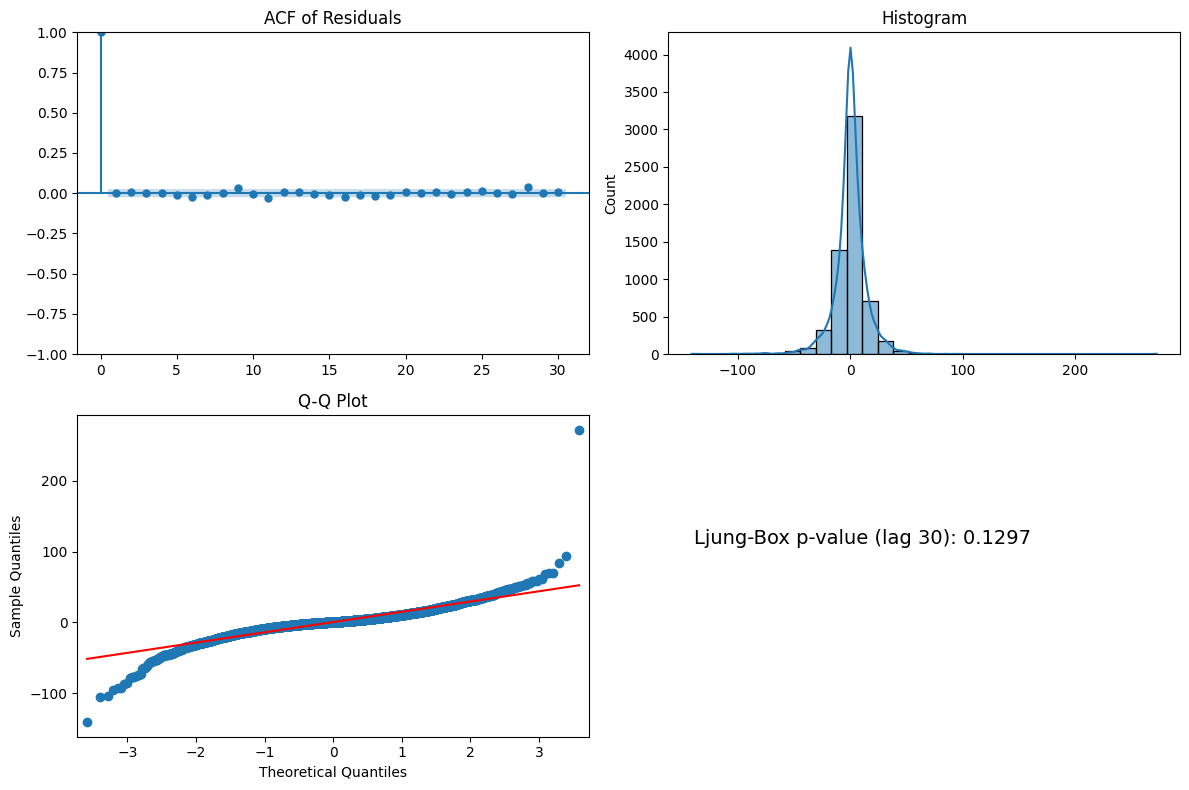

Top 5 ARIMA orders by AIC:
1. Order (4, 1, 3) → AIC: 48480.79
2. Order (3, 1, 3) → AIC: 48481.95
3. Order (2, 1, 1) → AIC: 48482.56
4. Order (1, 1, 2) → AIC: 48482.71
5. Order (4, 1, 4) → AIC: 48483.30
Fitted SARIMA(2, 1, 1)x(0, 0, 0, 12) - AIC: 48477.37
MAE:  246.1046
RMSE: 391.7625
MAPE: 10.49%


{'MAE': 246.1045677642016,
 'RMSE': 391.76254861373957,
 'MAPE': 10.493025838822053}

In [53]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter("ignore", ConvergenceWarning)

# 1. Fit ARIMA
from statsmodels.tsa.arima.model import ARIMA
close_series = dataset['Close'].dropna()
close_series.index = pd.DatetimeIndex(close_series.index).to_period("D")
model = ARIMA(close_series, order=(2, 1, 1))
model_fit = model.fit()

# 2. Residual diagnostics
plot_residual_diagnostics(model_fit)

# 3. AIC comparison
compare_arima_aic(close_series, p_range=range(0, 5), d_range=[1], q_range=range(0, 5))

# 4. SARIMA example
sarima_fit = fit_sarima_model(close_series, order=(2,1,1), seasonal_order=(0,0,0,12))

# 5. Evaluate forecast (split data first)
split_point = int(len(close_series) * 0.8)
train, test = close_series[:split_point], close_series[split_point:]
model = ARIMA(train, order=(2,1,1)).fit()
forecast = model.forecast(steps=len(test))
evaluate_forecast(test.values, forecast.values)


In [54]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
import tqdm

def rolling_origin_forecast(series, 
                             order=(2,1,1), 
                             seasonal_order=(0,0,0,12), 
                             initial_train_size=0.8, 
                             forecast_horizon=1, 
                             rolling_steps=50,
                             show_progress=True):
    """
    Rolling-origin forecast (walk-forward CV) for ARIMA/SARIMA models.

    Parameters:
    - series: time series data (Pandas Series)
    - order: ARIMA order (p,d,q)
    - seasonal_order: SARIMA seasonal order (P,D,Q,m)
    - initial_train_size: float or int (starting size of training set)
    - forecast_horizon: int (how many steps ahead to forecast each time)
    - rolling_steps: int (how many iterations)
    - show_progress: whether to show progress bar

    Returns:
    - DataFrame with true, predicted, and errors
    - Evaluation metrics: MAE, RMSE, MAPE
    """
    series = series.dropna()
    n_total = len(series)

    if isinstance(initial_train_size, float):
        initial_train_size = int(n_total * initial_train_size)

    y_true = []
    y_pred = []

    iterator = range(rolling_steps)
    if show_progress:
        iterator = tqdm.tqdm(iterator)

    for i in iterator:
        train_end = initial_train_size + i
        test_end = train_end + forecast_horizon

        if test_end > n_total:
            break

        train_data = series.iloc[:train_end]
        test_data = series.iloc[train_end:test_end]

        try:
            model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order,
                            enforce_stationarity=False, enforce_invertibility=False)
            model_fit = model.fit(disp=False)
            forecast = model_fit.forecast(steps=forecast_horizon)
            y_true.extend(test_data.values)
            y_pred.extend(forecast.values)
        except:
            # If model fails to converge, skip this window
            continue

    # Compute metrics
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100

    print(f"Rolling Forecast Evaluation:")
    print(f"  MAE : {mae:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAPE: {mape:.2f}%")

    results_df = pd.DataFrame({
        "Actual": y_true,
        "Predicted": y_pred,
        "Error": np.array(y_true) - np.array(y_pred)
    })

    return results_df, {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

# Assume `close_series` is your time series, and has daily frequency
close_series = dataset['Close'].dropna()
close_series.index = pd.DatetimeIndex(close_series.index).to_period("D")

# Use SARIMA (1,1,1)(1,1,1,12) from earlier
results_df, metrics = rolling_origin_forecast(
    close_series,
    order=(2, 1, 1),
    seasonal_order=(0, 0, 0, 12),
    initial_train_size=0.8,
    forecast_horizon = 1,
    rolling_steps=100
)


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]

Rolling Forecast Evaluation:
  MAE : 16.8003
  RMSE: 23.3723
  MAPE: 0.88%


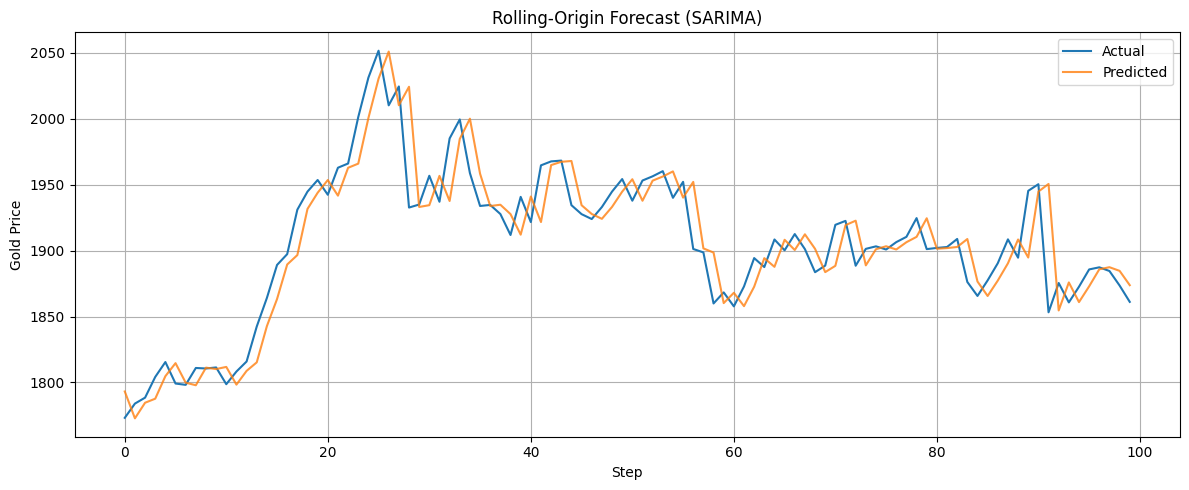

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(results_df['Actual'], label='Actual')
plt.plot(results_df['Predicted'], label='Predicted', alpha=0.8)
plt.title("Rolling-Origin Forecast (SARIMA)")
plt.xlabel("Step")
plt.ylabel("Gold Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [56]:
results_df.to_csv("sarima_rolling_forecast_results.csv", index=False)
